In [1]:
#importing libraries required
import os
import cv2
import json
import numpy as np
import tensorflow as tf
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import pandas as pd
import albumentations as A
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.utils import to_categorical, Sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Conv2D, MaxPooling2D, Flatten, Dense, Dropout, 
                                     BatchNormalization, GlobalAveragePooling2D, Input)
from tensorflow.keras.callbacks import EarlyStopping

2025-04-15 08:45:20.125072: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744706720.335142      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744706720.397850      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.5' (you have '2.0.4'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


100%|██████████| 856/856 [00:09<00:00, 94.49it/s] 


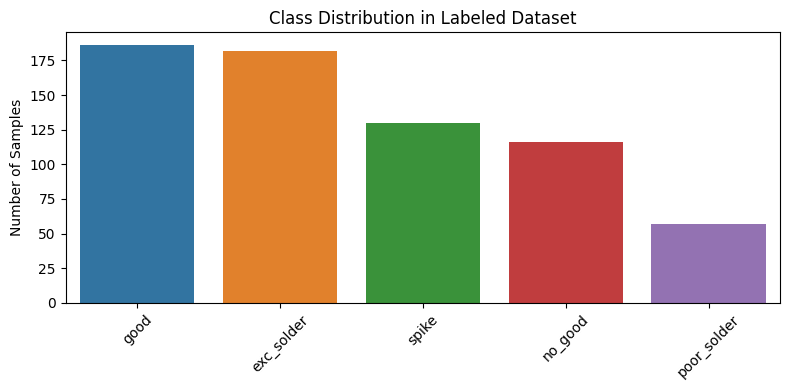

In [9]:
IMG_SIZE = (299, 299)
BATCH_SIZE = 32
base_dataset = '/kaggle/input/soldef-ai-pcb-dataset-for-defect-detection/SolDef_AI/Labeled'
# loading the labeled data:
def load_labeled_data(directory):
    images, masks, labels = [], [], []
    for file in tqdm(os.listdir(directory)):
        if file.endswith('.json'):
            json_path = os.path.join(directory, file)
            with open(json_path) as f:
                data = json.load(f)
            image_path = os.path.join(directory, data['imagePath'])
            if not os.path.exists(image_path):
                continue

            img = cv2.imread(image_path)
            img = cv2.resize(img, IMG_SIZE)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = img / 255.0

            # create mask based on polygon
            mask = np.zeros(img.shape[:2], dtype=np.uint8)
            for shape in data['shapes']:
                label = shape['label']
                points = np.array(shape['points'], dtype=np.int32)
                cv2.fillPoly(mask, [points], color=1)
                images.append(img)
                masks.append(mask)
                labels.append(label)
    return np.array(images), np.array(masks), np.array(labels)
images, masks, labels = load_labeled_data(base_dataset)

# class distribution of the original data 
label_counts = pd.Series(labels).value_counts()
plt.figure(figsize=(8, 4))
sns.barplot(x=label_counts.index, y=label_counts.values)
plt.title("Class Distribution in Labeled Dataset")
plt.ylabel("Number of Samples")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [10]:
#doing label encoding
y = LabelEncoder().fit_transform(labels)

# Split data into training and validation set (here named temp) and test sets
X_temp, X_test, y_temp, y_test = train_test_split(images, y, test_size=0.1, stratify=y, random_state=42)
y_temp_cat = to_categorical(y_temp)
y_test_cat = to_categorical(y_test)


In [11]:
# Data augmentation for training
aug = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1, rotate_limit=15, p=0.5),
    A.RandomBrightnessContrast(p=0.5)
])


/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:58: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


In [12]:
# function to build the cnn model
def build_cnn(input_shape, num_classes):
    model = Sequential([
        Input(shape=input_shape),

        Conv2D(32, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(32, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),

        Conv2D(64, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.3),

        Conv2D(128, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.4),

        GlobalAveragePooling2D(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model


In [13]:
#using k fold cross-validation on the dataset for training and validation set
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

best_model = None
best_val_accuracy = 0

for fold, (train_idx, val_idx) in enumerate(kf.split(X_temp, y_temp)):
    print(f"\n--- Fold {fold+1} ---")
    X_train, X_val = X_temp[train_idx], X_temp[val_idx]
    y_train, y_val = y_temp_cat[train_idx], y_temp_cat[val_idx]

    X_train_aug = []
    for img in X_train:
        augmented = aug(image=img)['image']
        X_train_aug.append(augmented)
    X_train_aug = np.array(X_train_aug)

    model = build_cnn((*IMG_SIZE, 3), len(np.unique(y)))
    early_stop = EarlyStopping(patience=5, restore_best_weights=True)

    history = model.fit(X_train_aug, y_train, validation_data=(X_val, y_val),
                        epochs=20, batch_size=32, callbacks=[early_stop])

    val_acc = history.history['val_accuracy'][-1]
    if val_acc > best_val_accuracy:
        best_val_accuracy = val_acc
        best_model = model


--- Fold 1 ---


I0000 00:00:1744706945.717064      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1744706945.717688      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Epoch 1/20


I0000 00:00:1744706954.476577     102 service.cc:148] XLA service 0x7ca9d0026910 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1744706954.477516     102 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1744706954.477536     102 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1744706955.176911     102 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-04-15 08:49:30.348734: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f32[32,32,3,3]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,32,299,299]{3,2,1,0}, f32[32,32,299,299]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardFilter", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_qu

16/16 ━━━━━━━━━━━━━━━━━━━━ 55s 2s/step - accuracy: 0.3389 - loss: 1.5135 - val_accuracy: 0.2727 - val_loss: 1.6163
Epoch 2/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 242ms/step - accuracy: 0.4041 - loss: 1.2651 - val_accuracy: 0.2727 - val_loss: 1.9046
Epoch 3/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 245ms/step - accuracy: 0.4626 - loss: 1.1626 - val_accuracy: 0.2727 - val_loss: 2.6230
Epoch 4/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 247ms/step - accuracy: 0.4188 - loss: 1.2031 - val_accuracy: 0.2727 - val_loss: 3.0658
Epoch 5/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 246ms/step - accuracy: 0.4562 - loss: 1.1310 - val_accuracy: 0.2727 - val_loss: 3.4902
Epoch 6/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 248ms/step - accuracy: 0.4785 - loss: 1.1160 - val_accuracy: 0.2727 - val_loss: 4.4357

--- Fold 2 ---
Epoch 1/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 21s 667ms/step - accuracy: 0.3141 - loss: 1.6053 - val_accuracy: 0.2645 - val_loss: 1.5955
Epoch 2/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 253ms/step - accuracy: 0.4017 - loss: 1.2257 - val_accuracy

3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step 
              precision    recall  f1-score   support

           0       0.26      1.00      0.42        18
           1       0.00      0.00      0.00        19
           2       0.00      0.00      0.00        12
           3       0.00      0.00      0.00         6
           4       0.00      0.00      0.00        13

    accuracy                           0.26        68
   macro avg       0.05      0.20      0.08        68
weighted avg       0.07      0.26      0.11        68



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


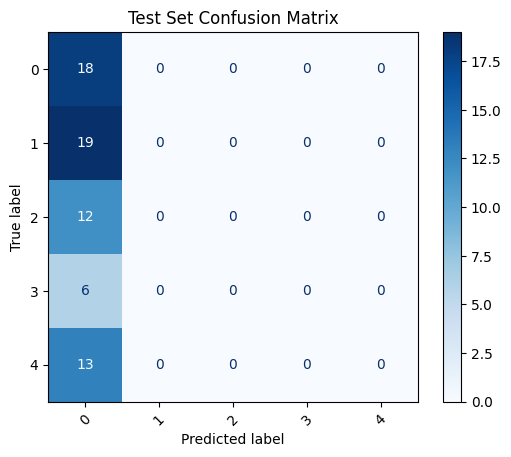

In [17]:
y_test_pred = np.argmax(best_model.predict(X_test), axis=1)
y_test_true = np.argmax(y_test_cat, axis=1)

print(classification_report(y_test_true, y_test_pred))

cm = confusion_matrix(y_test_true, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Test Set Confusion Matrix")
plt.show()

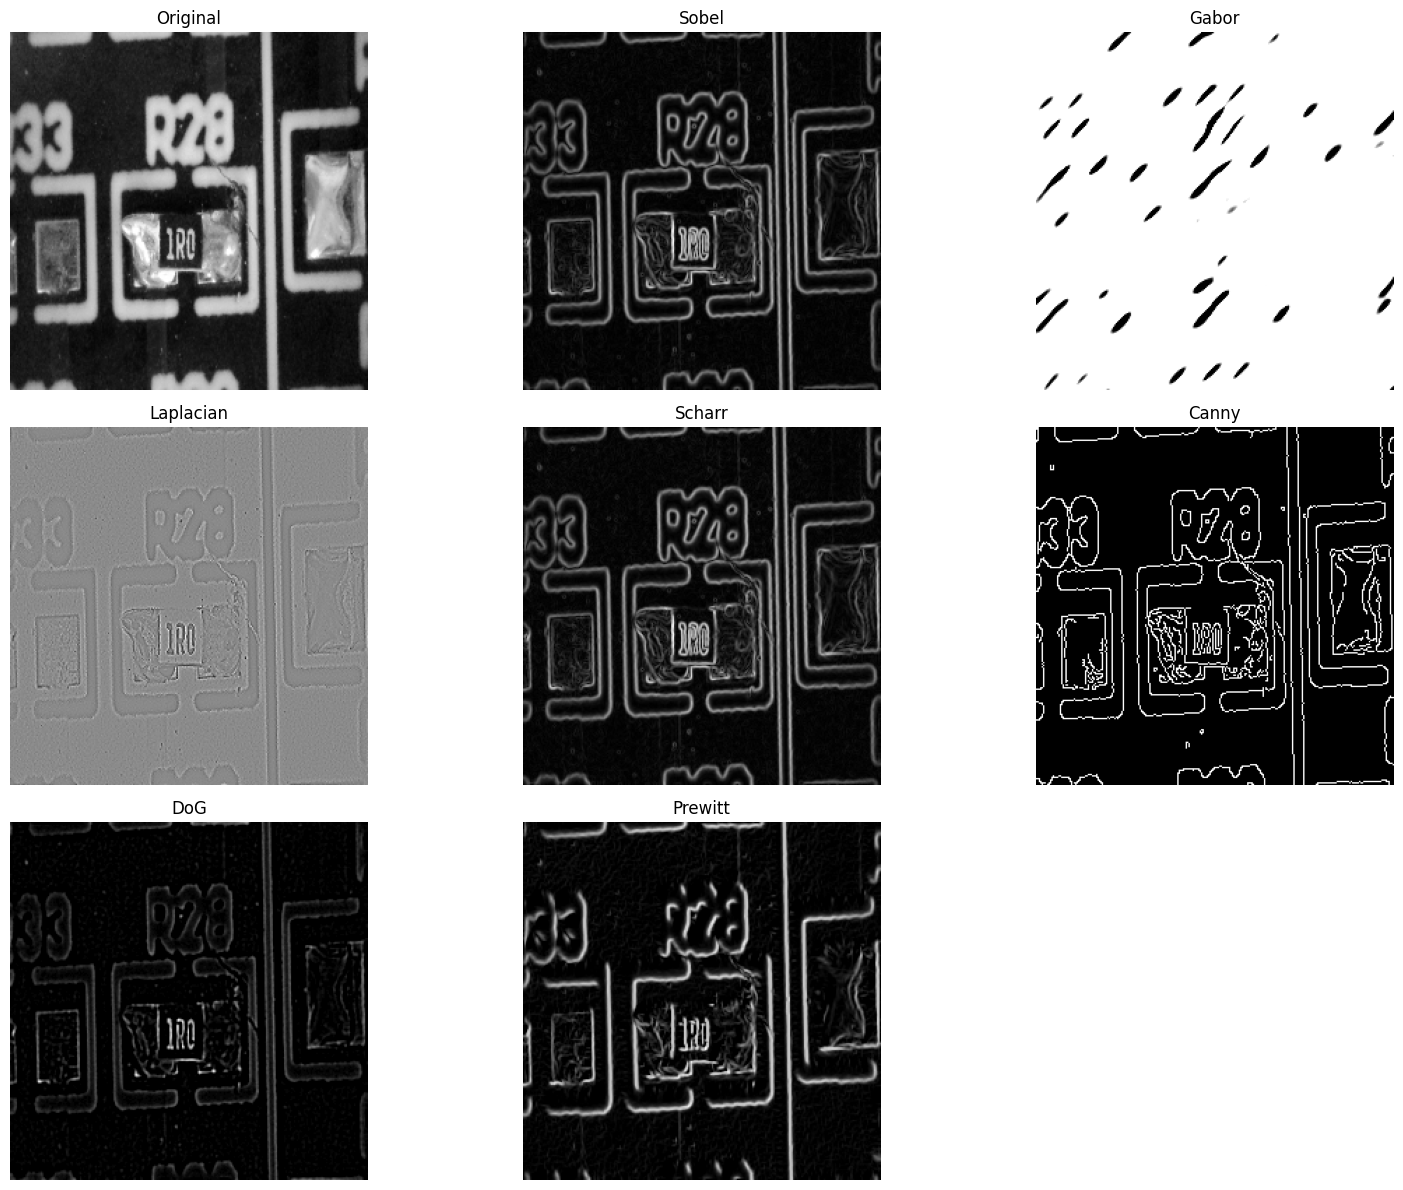

In [18]:
sample_image = (images[0] * 255).astype('uint8')
sample_gray = cv2.cvtColor(sample_image, cv2.COLOR_RGB2GRAY)
sample_gray = cv2.resize(sample_gray, (256, 256))

sobel = cv2.magnitude(cv2.Sobel(sample_gray, cv2.CV_64F, 1, 0), cv2.Sobel(sample_gray, cv2.CV_64F, 0, 1))
gabor = cv2.filter2D(sample_gray, cv2.CV_8UC3, cv2.getGaborKernel((21, 21), 4.0, np.pi / 4, 10.0, 0.5, 0))
laplacian = cv2.Laplacian(sample_gray, cv2.CV_64F)
scharr = cv2.magnitude(cv2.Scharr(sample_gray, cv2.CV_64F, 1, 0), cv2.Scharr(sample_gray, cv2.CV_64F, 0, 1))
canny = cv2.Canny(sample_gray, 100, 200)
dog = cv2.subtract(cv2.GaussianBlur(sample_gray, (3, 3), 1), cv2.GaussianBlur(sample_gray, (5, 5), 2))
prewitt = cv2.magnitude(
    np.float32(cv2.filter2D(sample_gray, -1, np.array([[1,0,-1],[1,0,-1],[1,0,-1]]))),
    np.float32(cv2.filter2D(sample_gray, -1, np.array([[1,1,1],[0,0,0],[-1,-1,-1]])))
)

titles = ['Original', 'Sobel', 'Gabor', 'Laplacian', 'Scharr', 'Canny', 'DoG', 'Prewitt']
images_all = [sample_gray, sobel, gabor, laplacian, scharr, canny, dog, prewitt]

plt.figure(figsize=(16, 12))
for i in range(8):
    plt.subplot(3, 3, i + 1)
    plt.imshow(images_all[i], cmap='gray')
    plt.title(titles[i])
    plt.axis('off')
plt.tight_layout()
plt.show()

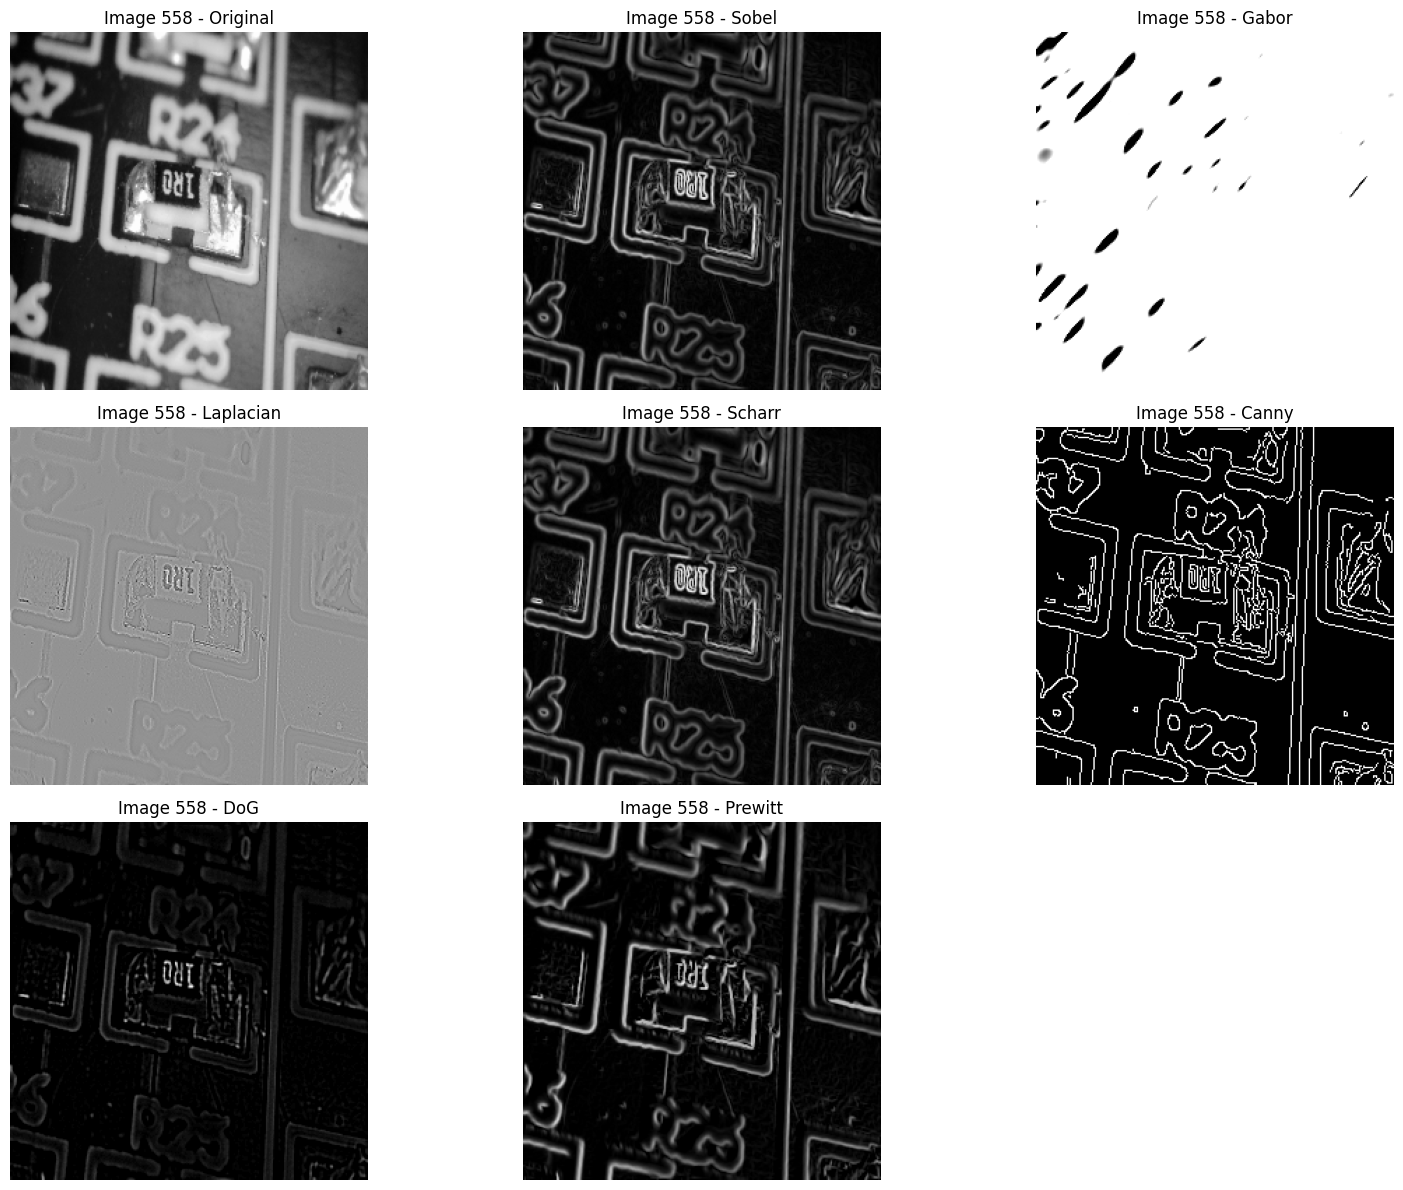

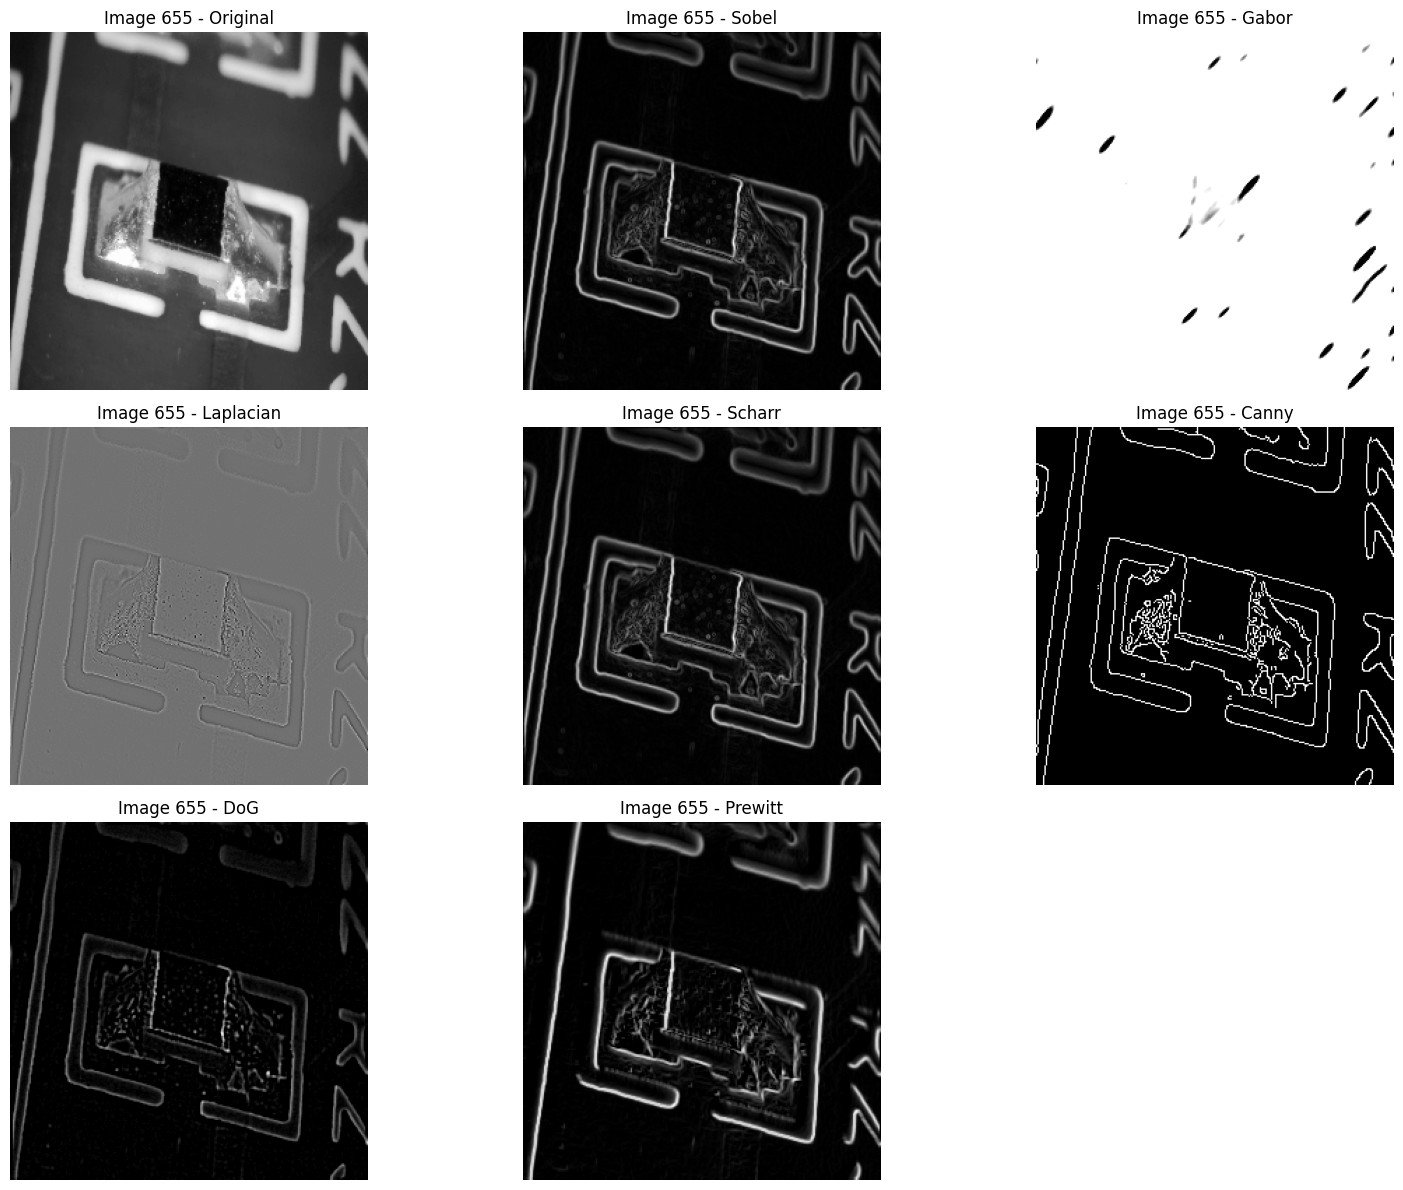

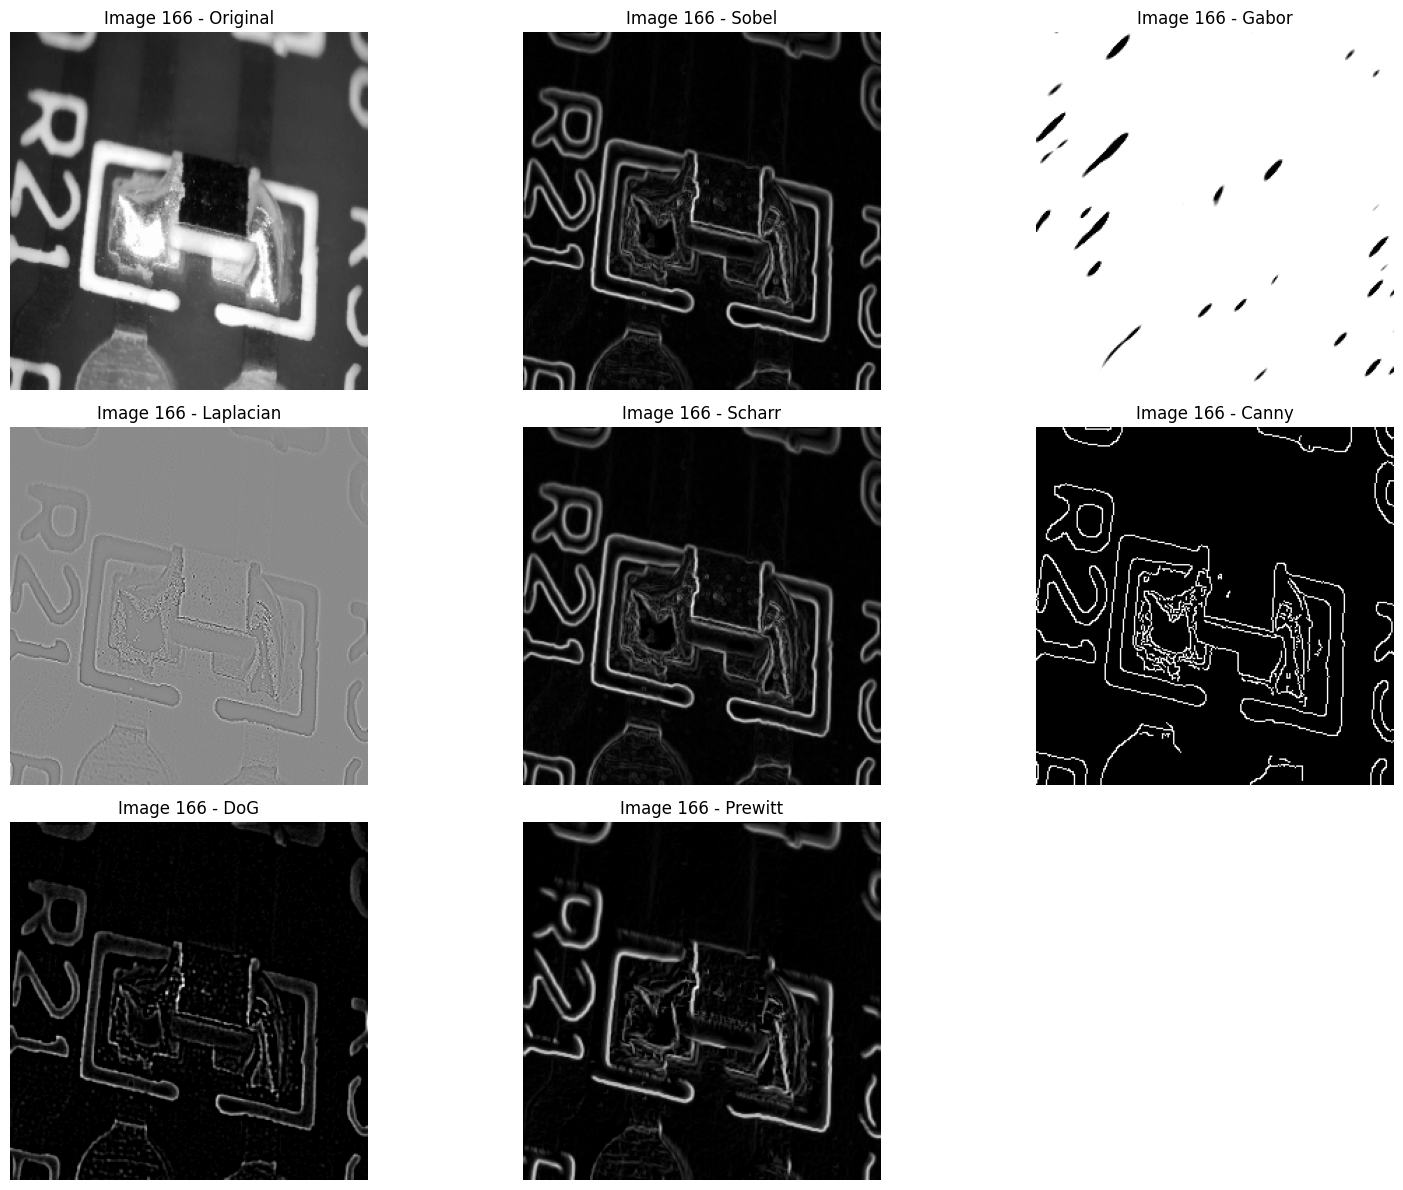

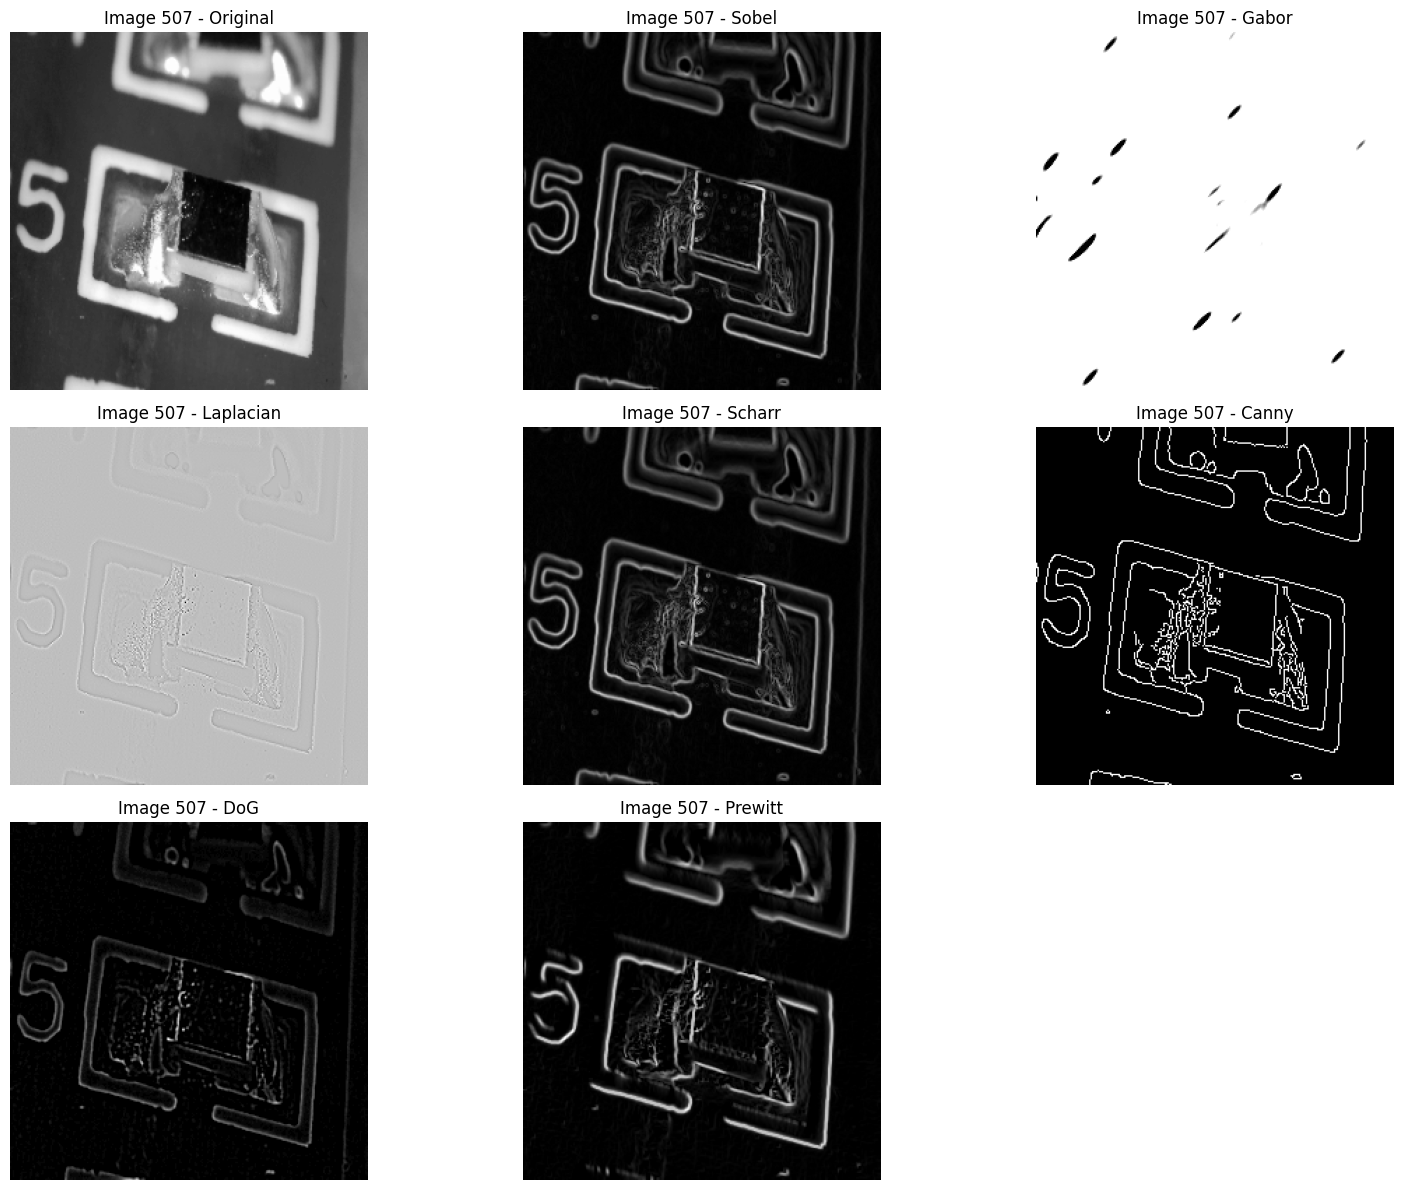

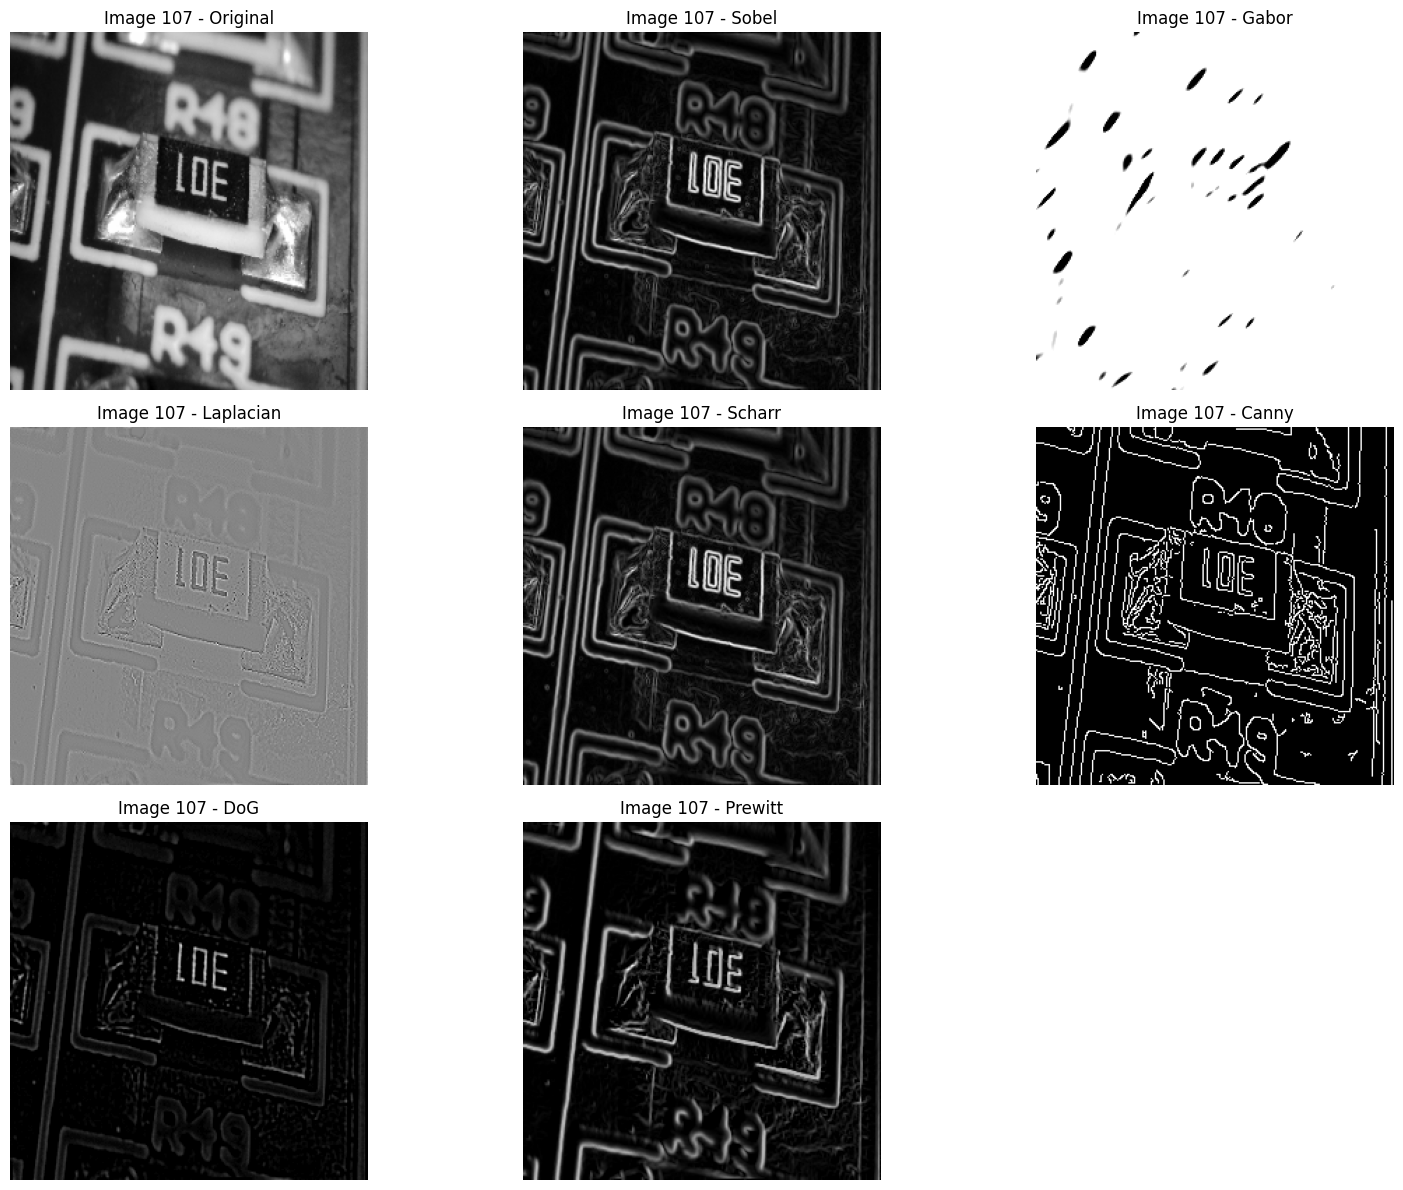

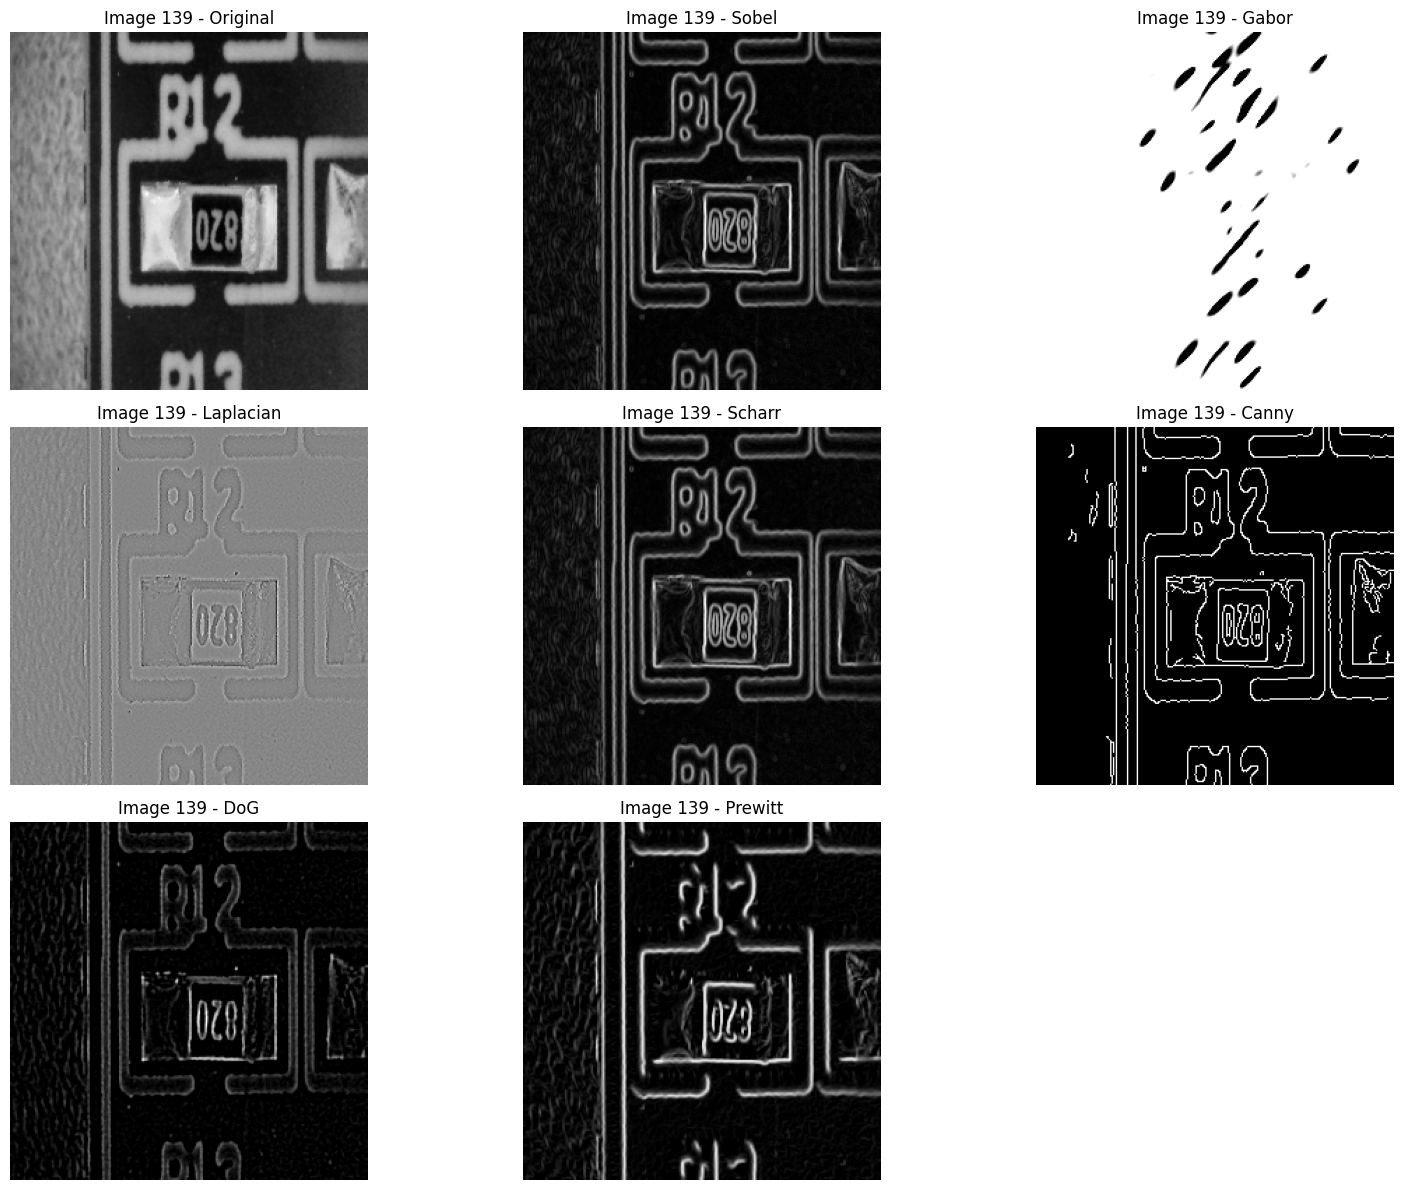

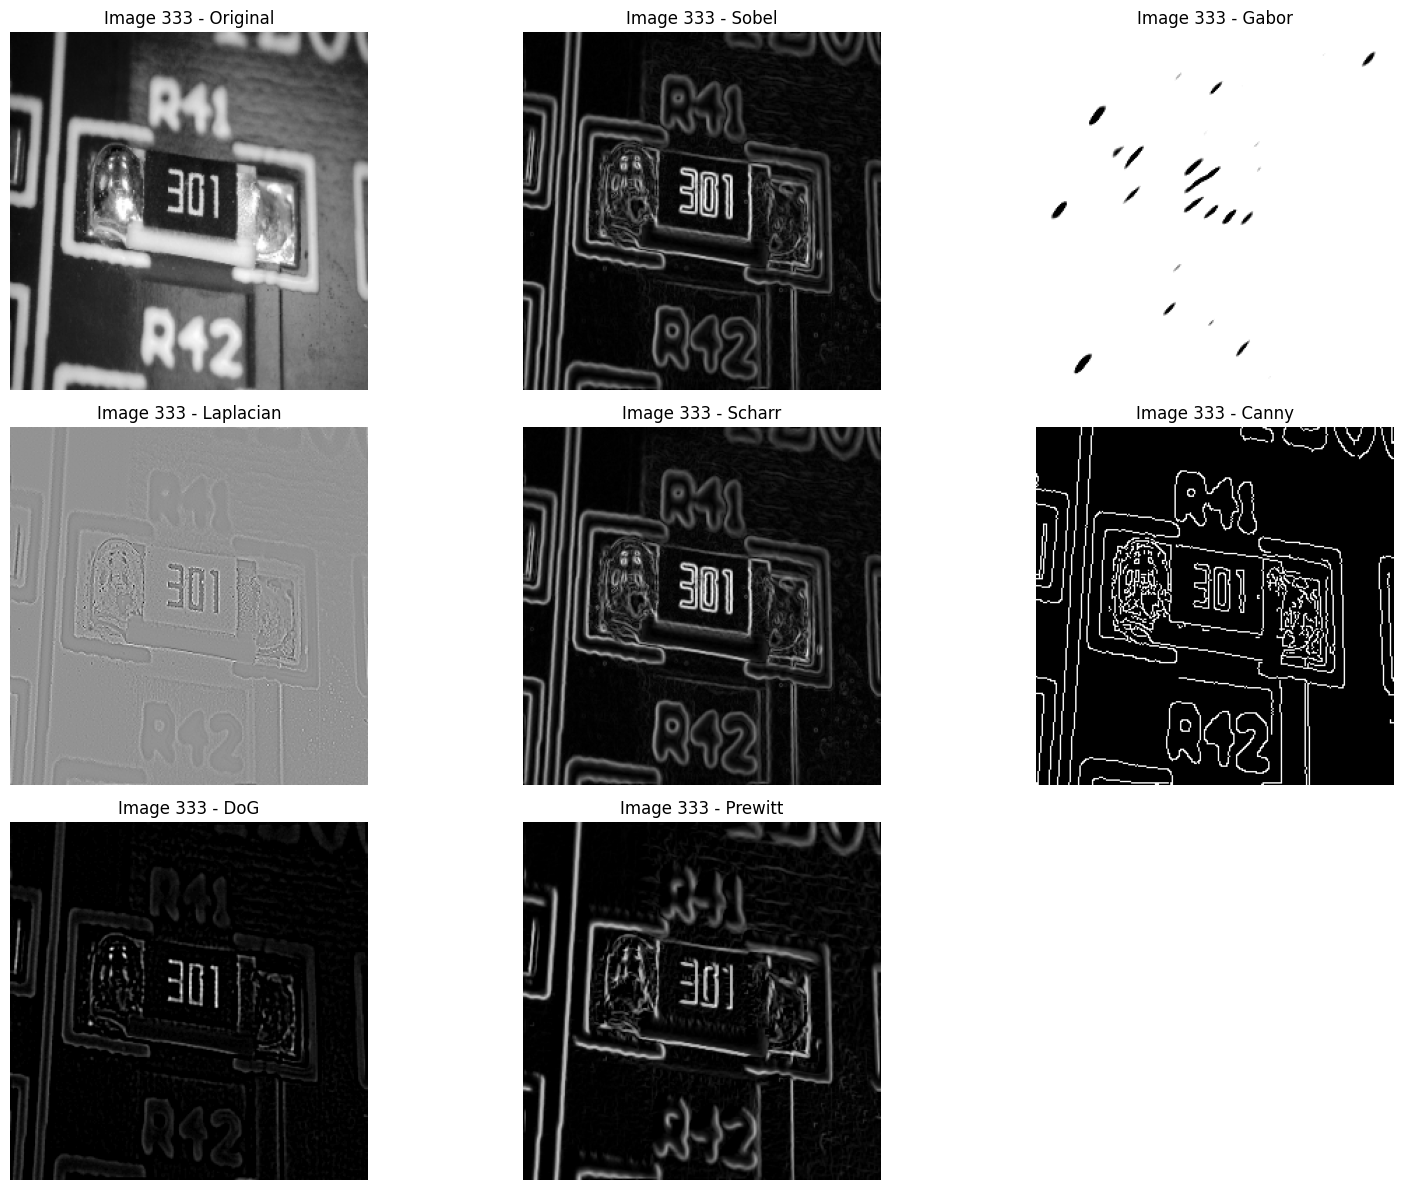

In [19]:
import random
import matplotlib.pyplot as plt
import numpy as np
import cv2

def apply_filters(image_rgb):
    sample_gray = cv2.cvtColor((image_rgb * 255).astype('uint8'), cv2.COLOR_RGB2GRAY)
    sample_gray = cv2.resize(sample_gray, (256, 256))

    sobel = cv2.magnitude(cv2.Sobel(sample_gray, cv2.CV_64F, 1, 0), cv2.Sobel(sample_gray, cv2.CV_64F, 0, 1))
    gabor = cv2.filter2D(sample_gray, cv2.CV_8UC3, cv2.getGaborKernel((21, 21), 4.0, np.pi / 4, 10.0, 0.5, 0))
    laplacian = cv2.Laplacian(sample_gray, cv2.CV_64F)
    scharr = cv2.magnitude(cv2.Scharr(sample_gray, cv2.CV_64F, 1, 0), cv2.Scharr(sample_gray, cv2.CV_64F, 0, 1))
    canny = cv2.Canny(sample_gray, 100, 200)
    dog = cv2.subtract(cv2.GaussianBlur(sample_gray, (3, 3), 1), cv2.GaussianBlur(sample_gray, (5, 5), 2))
    prewitt = cv2.magnitude(
        np.float32(cv2.filter2D(sample_gray, -1, np.array([[1, 0, -1], [1, 0, -1], [1, 0, -1]]))),
        np.float32(cv2.filter2D(sample_gray, -1, np.array([[1, 1, 1], [0, 0, 0], [-1, -1, -1]])))
    )

    titles = ['Original', 'Sobel', 'Gabor', 'Laplacian', 'Scharr', 'Canny', 'DoG', 'Prewitt']
    images_all = [sample_gray, sobel, gabor, laplacian, scharr, canny, dog, prewitt]

    return titles, images_all

# Pick 7 random indices
random_indices = random.sample(range(len(images)), 7)

# Apply to each and plot
for idx, img_index in enumerate(random_indices):
    titles, outputs = apply_filters(images[img_index])

    plt.figure(figsize=(16, 12))
    for i in range(8):
        plt.subplot(3, 3, i + 1)
        plt.imshow(outputs[i], cmap='gray')
        plt.title(f"Image {img_index} - {titles[i]}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()
